In [1]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import BertTokenizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from keras.callbacks import Callback
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, GlobalAveragePooling1D, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.layers import Layer, GRU, Bidirectional, Dense, Input, Reshape, GlobalAveragePooling1D
import nltk
from nltk.corpus import wordnet
import random
from lime.lime_text import LimeTextExplainer

nltk.download('punkt')

f:\Mini Conda\envs\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df = pd.read_csv(r"F:\Aspect Based Sentiment Analysis\Resturant\Restaurant - Sheet1.csv")
df.head()

,SL,Text,Category,Polarity
0,0,"স্টাফ কিন্তু, আমাদের জন্য ভয়ঙ্কর ছিল।",service,negative
1,1,"শুধুমাত্র,রিডামিং ফ্যাক্টর খাদ্য ছিল,পুরোপুরি ...",food,positive
2,2,"শুধুমাত্র,রিডামিং ফ্যাক্টর খাদ্য ছিল,পুরোপুরি ...",anecdotes/miscellaneous,negative
3,3,"খাবার একদমই ব্যতিক্রমী, একটি খুব সক্ষম রান্নাঘ...",food,positive
4,4,যেখানে গাব্রিয়েলা লোকালি আপনাকে শুভেচ্ছা জানা...,service,positive


In [3]:
df = df[['Text', 'Category', 'Polarity']]
df.head()

,Text,Category,Polarity
0,"স্টাফ কিন্তু, আমাদের জন্য ভয়ঙ্কর ছিল।",service,negative
1,"শুধুমাত্র,রিডামিং ফ্যাক্টর খাদ্য ছিল,পুরোপুরি ...",food,positive
2,"শুধুমাত্র,রিডামিং ফ্যাক্টর খাদ্য ছিল,পুরোপুরি ...",anecdotes/miscellaneous,negative
3,"খাবার একদমই ব্যতিক্রমী, একটি খুব সক্ষম রান্নাঘ...",food,positive
4,যেখানে গাব্রিয়েলা লোকালি আপনাকে শুভেচ্ছা জানা...,service,positive


In [4]:
df['Category'].value_counts()

Category
food                       710
anecdotes/miscellaneous    610
service                    333
ambience                   231
price                      175
Name: count, dtype: int64

In [5]:
df['Polarity'].value_counts()

Polarity
positive    1221
negative     472
neutral      251
conflict     115
Name: count, dtype: int64

In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize Bengali stopwords and lemmatizer
stop_words = set(stopwords.words('bengali'))
lemmatizer = WordNetLemmatizer()

# Function to clean text
def clean_text(text):
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)  # Keep only Bengali characters
    text = re.sub(r'\d+', '', text)                 # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()        # Remove extra spaces

    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    return ' '.join(words)

df['Text'] = df['Text'].apply(clean_text)
df.head()

,Text,Category,Polarity
0,স্টাফ ভয়ঙ্কর,service,negative
1,শুধুমাত্ররিডামিং ফ্যাক্টর খাদ্য ছিলপুরোপুরি ন্...,food,positive
2,শুধুমাত্ররিডামিং ফ্যাক্টর খাদ্য ছিলপুরোপুরি ন্...,anecdotes/miscellaneous,negative
3,খাবার একদমই ব্যতিক্রমী সক্ষম রান্নাঘর গর্বের খ...,food,positive
4,গাব্রিয়েলা লোকালি আপনাকে শুভেচ্ছা আপনাকে খেতে...,service,positive


In [7]:
from sklearn.utils import resample

# Define a function to perform random upsampling
def upsample(df, target_column):
    # Get the maximum count of samples in any class
    max_count = df[target_column].value_counts().max()

    # Separate each class and upsample the minority classes
    upsampled_dfs = []
    for label in df[target_column].unique():
        # Get samples for the current label
        df_label = df[df[target_column] == label]

        # Upsample minority classes to match the majority class count
        df_upsampled = resample(
            df_label,
            replace=True,            # Sample with replacement
            n_samples=max_count,     # Match the number of samples in the majority class
            random_state=42          # Set random seed for reproducibility
        )
        upsampled_dfs.append(df_upsampled)

    # Combine the upsampled DataFrames
    return pd.concat(upsampled_dfs)

# Apply upsampling to 'Category' and 'Polarity'
df_upsampled_category = upsample(df, 'Category')
df_upsampled_polarity = upsample(df_upsampled_category, 'Polarity')

# Shuffle the DataFrame to mix the resampled classes
df_upsampled = df_upsampled_polarity.sample(frac=1, random_state=42).reset_index(drop=True)

# Display new class distribution
print("Category distribution after upsampling:")
print(df_upsampled['Category'].value_counts())
print("\nPolarity distribution after upsampling:")
print(df_upsampled['Polarity'].value_counts())


Category distribution after upsampling:
Category
anecdotes/miscellaneous    2091
ambience                   1929
service                    1506
price                      1394
food                       1308
Name: count, dtype: int64

Polarity distribution after upsampling:
Polarity
positive    2057
neutral     2057
conflict    2057
negative    2057
Name: count, dtype: int64


In [8]:
df_upsampled.head()

,Text,Category,Polarity
0,মহান আদেশ ছিলআমার বন্ধু সুশি রোলসের চমৎকার উপস...,food,positive
1,আমদের আট গ্রুপ ভাল,anecdotes/miscellaneous,neutral
2,একটু দামী কামড় মূল্য,price,conflict
3,খাদ্য সমালোচক নই গত বছরে এনওয়াইতে বসবাসরত সময...,anecdotes/miscellaneous,neutral
4,এনওয়াইসি দেখি সুন্দর সুন্দর,ambience,positive


In [9]:
from sklearn.preprocessing import LabelEncoder

category_encoder = LabelEncoder()
polarity_encoder = LabelEncoder()

df_upsampled['Category_encoded'] = category_encoder.fit_transform(df_upsampled['Category'])
df_upsampled['Polarity_encoded'] = polarity_encoder.fit_transform(df_upsampled['Polarity'])

In [10]:
adsfa

NameError: name 'adsfa' is not defined

In [ ]:
# Tokenize the text using DistilBERT with padding and truncation
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')


f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
def tokenize_function(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='np')

df_upsampled['tokens'] = df_upsampled['Text'].apply(lambda x: tokenize_function(x))

# Train-test split
train_df, test_df = train_test_split(df_upsampled, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

In [ ]:
# Convert to TensorFlow Dataset
def create_tensor_dataset(df):
    # Tokenize input text and convert to TensorFlow tensors
    inputs = tokenizer(list(df['Text']), padding='max_length', truncation=True, max_length=128, return_tensors='tf')
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # Convert labels to tensors
    labels_category = tf.convert_to_tensor(df['Category_encoded'].values)
    labels_polarity = tf.convert_to_tensor(df['Polarity_encoded'].values)

    return tf.data.Dataset.from_tensor_slices(((input_ids, attention_mask), (labels_category, labels_polarity)))


In [ ]:
from transformers import TFBertModel

class BertLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = TFBertModel.from_pretrained('bert-base-multilingual-cased')

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        return outputs.pooler_output


# Define the model inputs
input_ids = tf.keras.Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

# Bert Layer
bert_output = BertLayer()([input_ids, attention_mask])

# Multi-task model
category_output = tf.keras.layers.Dense(5, activation='softmax', name='category_output')(bert_output)
polarity_output = tf.keras.layers.Dense(4, activation='softmax', name='polarity_output')(bert_output)

multi_task_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[category_output, polarity_output])

# Compile the model
multi_task_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss={
        'category_output': 'sparse_categorical_crossentropy',
        'polarity_output': 'sparse_categorical_crossentropy'
    },
    metrics=['accuracy']
)

multi_task_model.summary()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 bert_layer_1 (BertLayer)       (None, 768)          177853440   ['input_ids[0][0]',              
                                                                  'attention_mask[0][0]']         
                                                                                                  
 category_output (Dense)        (None, 5)            3845        ['bert_layer_1[0][0]']     

In [ ]:
# Create train and validation datasets
train_dataset = create_tensor_dataset(train_df)
val_dataset = create_tensor_dataset(val_df)

In [ ]:
history = multi_task_model.fit(
    train_dataset.batch(8), 
    epochs=5, 
    validation_data=val_dataset.batch(8)
)

Epoch 1/5
741/741 [==============================] - 201s 250ms/step - loss: 2.0325 - category_output_loss: 1.0692 - polarity_output_loss: 0.9633 - category_output_accuracy: 0.5693 - polarity_output_accuracy: 0.5632 - val_loss: 0.9882 - val_category_output_loss: 0.4807 - val_polarity_output_loss: 0.5075 - val_category_output_accuracy: 0.8392 - val_polarity_output_accuracy: 0.8118
Epoch 2/5
741/741 [==============================] - 208s 281ms/step - loss: 0.7684 - category_output_loss: 0.4364 - polarity_output_loss: 0.3320 - category_output_accuracy: 0.8582 - polarity_output_accuracy: 0.8808 - val_loss: 0.6037 - val_category_output_loss: 0.3670 - val_polarity_output_loss: 0.2367 - val_category_output_accuracy: 0.8953 - val_polarity_output_accuracy: 0.9256
Epoch 3/5
741/741 [==============================] - 204s 275ms/step - loss: 0.4983 - category_output_loss: 0.3101 - polarity_output_loss: 0.1882 - category_output_accuracy: 0.8985 - polarity_output_accuracy: 0.9363 - val_loss: 0.5176

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# Create the test dataset with batching
test_dataset = create_tensor_dataset(test_df)

# Evaluate the model on the test dataset
test_metrics = multi_task_model.evaluate(test_dataset.batch(8))
print(f"Test Category Loss: {test_metrics[1]}, Test Category Accuracy: {test_metrics[3]}")
print(f"Test Polarity Loss: {test_metrics[2]}, Test Polarity Accuracy: {test_metrics[4]}")


206/206 [==============================] - 22s 109ms/step - loss: 0.4774 - category_output_loss: 0.3347 - polarity_output_loss: 0.1427 - category_output_accuracy: 0.8913 - polarity_output_accuracy: 0.9563
Test Category Loss: 0.33471137285232544, Test Category Accuracy: 0.8912515044212341
Test Polarity Loss: 0.14266248047351837, Test Polarity Accuracy: 0.9562575817108154


103/103 [==============================] - 18s 138ms/step
Category Classification Report:
                          precision    recall  f1-score   support

               ambience       0.94      0.89      0.91       396
anecdotes/miscellaneous       0.95      0.94      0.94       410
                   food       0.76      0.89      0.82       264
                  price       0.82      0.92      0.87       266
                service       0.95      0.82      0.88       310

               accuracy                           0.89      1646
              macro avg       0.89      0.89      0.89      1646
           weighted avg       0.90      0.89      0.89      1646

Polarity Classification Report:
               precision    recall  f1-score   support

    conflict       0.97      1.00      0.98       416
    negative       0.95      0.92      0.94       410
     neutral       0.98      0.98      0.98       424
    positive       0.92      0.93      0.93       396

    accuracy    

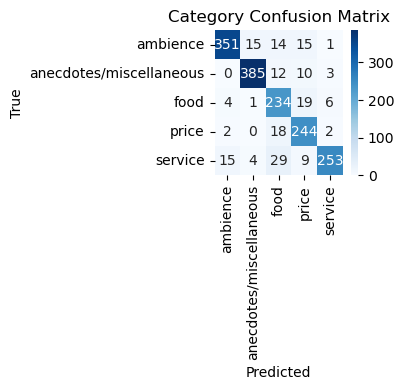

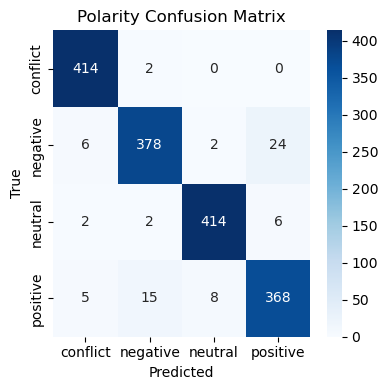

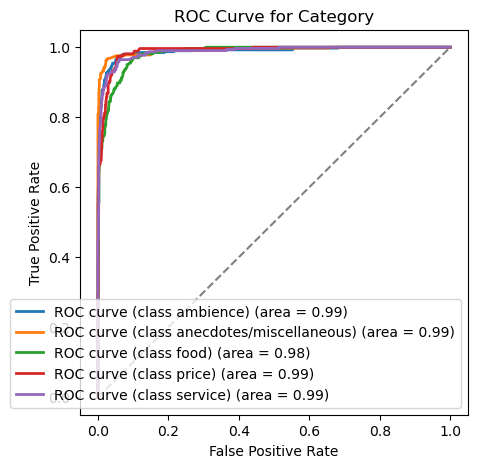

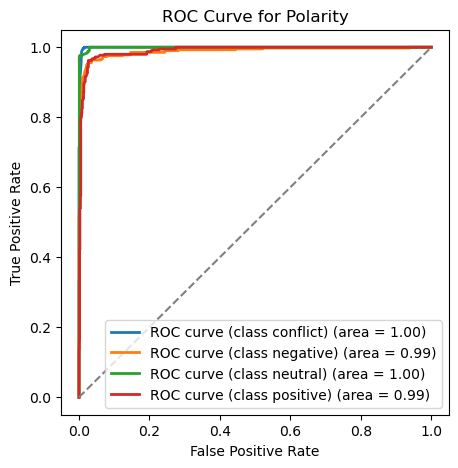

In [ ]:
predictions = multi_task_model.predict(test_dataset.batch(16))

# Assign predicted probabilities
category_probs = predictions[0] 
polarity_probs = predictions[1]  

# Step 2: Convert predictions to class labels
category_pred = np.argmax(category_probs, axis=1) 
polarity_pred = np.argmax(polarity_probs, axis=1) 

# Step 3: Convert true labels to numpy arrays
category_true = test_df['Category_encoded'].values
polarity_true = test_df['Polarity_encoded'].values

# Step 4: Calculate classification report for category and polarity
category_report = classification_report(category_true, category_pred, target_names=category_encoder.classes_)
polarity_report = classification_report(polarity_true, polarity_pred, target_names=polarity_encoder.classes_)

# Print the classification reports
print("Category Classification Report:\n", category_report)
print("Polarity Classification Report:\n", polarity_report)

# Step 5: Generate confusion matrices
category_cm = confusion_matrix(category_true, category_pred)
polarity_cm = confusion_matrix(polarity_true, polarity_pred)

# Category Confusion Matrix
plt.figure(figsize=(4, 4))
sns.heatmap(category_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=category_encoder.classes_, yticklabels=category_encoder.classes_)
plt.title('Category Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Polarity Confusion Matrix
plt.figure(figsize=(4, 4))
sns.heatmap(polarity_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=polarity_encoder.classes_, yticklabels=polarity_encoder.classes_)
plt.title('Polarity Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize the labels for multi-class ROC
category_true_binarized = label_binarize(category_true, classes=np.arange(len(category_encoder.classes_)))
polarity_true_binarized = label_binarize(polarity_true, classes=np.arange(len(polarity_encoder.classes_)))

# Compute ROC curve and AUC for each class
fpr_category = {}
tpr_category = {}
roc_auc_category = {}
fpr_polarity = {}
tpr_polarity = {}
roc_auc_polarity = {}

# For category
for i in range(category_true_binarized.shape[1]):
    fpr_category[i], tpr_category[i], _ = roc_curve(category_true_binarized[:, i], category_probs[:, i])
    roc_auc_category[i] = auc(fpr_category[i], tpr_category[i])

# For polarity
for i in range(polarity_true_binarized.shape[1]):
    fpr_polarity[i], tpr_polarity[i], _ = roc_curve(polarity_true_binarized[:, i], polarity_probs[:, i])
    roc_auc_polarity[i] = auc(fpr_polarity[i], tpr_polarity[i])

# Plot ROC curves for Category
plt.figure(figsize=(5, 5))
for i in range(len(category_encoder.classes_)):
    plt.plot(fpr_category[i], tpr_category[i], lw=2,
             label='ROC curve (class %s) (area = %0.2f)' % (category_encoder.classes_[i], roc_auc_category[i]))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Category')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curves for Polarity
plt.figure(figsize=(5, 5))
for i in range(len(polarity_encoder.classes_)):
    plt.plot(fpr_polarity[i], tpr_polarity[i], lw=2,
             label='ROC curve (class %s) (area = %0.2f)' % (polarity_encoder.classes_[i], roc_auc_polarity[i]))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Polarity')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Step 7: Macro Precision, Recall, F1-Score Calculation
from sklearn.metrics import precision_score, recall_score, f1_score

# Macro precision, recall, and F1-score for category
macro_precision_category = precision_score(category_true, category_pred, average='macro')
macro_recall_category = recall_score(category_true, category_pred, average='macro')
macro_f1_category = f1_score(category_true, category_pred, average='macro')

# Macro precision, recall, and F1-score for polarity
macro_precision_polarity = precision_score(polarity_true, polarity_pred, average='macro')
macro_recall_polarity = recall_score(polarity_true, polarity_pred, average='macro')
macro_f1_polarity = f1_score(polarity_true, polarity_pred, average='macro')

# Print macro scores
print(f"Macro Precision (Category): {macro_precision_category:.4f}")
print(f"Macro Recall (Category): {macro_recall_category:.4f}")
print(f"Macro F1-Score (Category): {macro_f1_category:.4f}")
print(f"Macro Precision (Polarity): {macro_precision_polarity:.4f}")
print(f"Macro Recall (Polarity): {macro_recall_polarity:.4f}")
print(f"Macro F1-Score (Polarity): {macro_f1_polarity:.4f}")

Macro Precision (Category): 0.8865
Macro Recall (Category): 0.8890
Macro F1-Score (Category): 0.8850
Macro Precision (Polarity): 0.9557
Macro Recall (Polarity): 0.9557
Macro F1-Score (Polarity): 0.9556


In [ ]:
from transformers import TFBertModel, BertTokenizer
import tensorflow as tf

# Load tokenizer and model with the same model name
tokenizer = BertTokenizer.from_pretrained("sagorsarker/bangla-bert-base")


f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
def tokenize_function(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='np')

df_upsampled['tokens'] = df_upsampled['Text'].apply(lambda x: tokenize_function(x))

# Train-test split
train_df, test_df = train_test_split(df_upsampled, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

In [ ]:
# Convert to TensorFlow Dataset
def create_tensor_dataset(df):
    # Tokenize input text and convert to TensorFlow tensors
    inputs = tokenizer(list(df['Text']), padding='max_length', truncation=True, max_length=128, return_tensors='tf')
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # Convert labels to tensors
    labels_category = tf.convert_to_tensor(df['Category_encoded'].values)
    labels_polarity = tf.convert_to_tensor(df['Polarity_encoded'].values)

    return tf.data.Dataset.from_tensor_slices(((input_ids, attention_mask), (labels_category, labels_polarity)))


In [ ]:
from transformers import TFBertModel, BertTokenizer
import tensorflow as tf

class BertLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = TFBertModel.from_pretrained("sagorsarker/bangla-bert-base")

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state[:, 0, :]  # CLS token output for classification

# Define the model inputs
input_ids = tf.keras.Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

# Bert Layer
bert_output = BertLayer()([input_ids, attention_mask])

# Multi-task model
category_output = tf.keras.layers.Dense(5, activation='softmax', name='category_output')(bert_output)
polarity_output = tf.keras.layers.Dense(4, activation='softmax', name='polarity_output')(bert_output)

multi_task_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[category_output, polarity_output])

# Compile the model
multi_task_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss={
        'category_output': 'sparse_categorical_crossentropy',
        'polarity_output': 'sparse_categorical_crossentropy'
    },
    metrics=['accuracy']
)

multi_task_model.summary()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 bert_layer_2 (BertLayer)       (None, 768)          164396544   ['input_ids[0][0]',              
                                                                  'attention_mask[0][0]']         
                                                                                                  
 category_output (Dense)        (None, 5)            3845        ['bert_layer_2[0][0]']     

In [ ]:
# Create train and validation datasets
train_dataset = create_tensor_dataset(train_df)
val_dataset = create_tensor_dataset(val_df)

In [ ]:
history = multi_task_model.fit(
    train_dataset.batch(4), 
    epochs=5, 
    validation_data=val_dataset.batch(4)
)

Epoch 1/5
1481/1481 [==============================] - 252s 161ms/step - loss: 1.3729 - category_output_loss: 0.7352 - polarity_output_loss: 0.6377 - category_output_accuracy: 0.7381 - polarity_output_accuracy: 0.7579 - val_loss: 0.6133 - val_category_output_loss: 0.3975 - val_polarity_output_loss: 0.2158 - val_category_output_accuracy: 0.8847 - val_polarity_output_accuracy: 0.9317
Epoch 2/5
1481/1481 [==============================] - 301s 203ms/step - loss: 0.5308 - category_output_loss: 0.3422 - polarity_output_loss: 0.1885 - category_output_accuracy: 0.8877 - polarity_output_accuracy: 0.9412 - val_loss: 0.5221 - val_category_output_loss: 0.3459 - val_polarity_output_loss: 0.1762 - val_category_output_accuracy: 0.9044 - val_polarity_output_accuracy: 0.9560
Epoch 3/5
1481/1481 [==============================] - 312s 210ms/step - loss: 0.4058 - category_output_loss: 0.2692 - polarity_output_loss: 0.1366 - category_output_accuracy: 0.9124 - polarity_output_accuracy: 0.9596 - val_loss: 

In [ ]:
# Create the test dataset with batching
test_dataset = create_tensor_dataset(test_df)

# Evaluate the model on the test dataset
test_metrics = multi_task_model.evaluate(test_dataset.batch(4))
print(f"Test Category Loss: {test_metrics[1]}, Test Category Accuracy: {test_metrics[3]}")
print(f"Test Polarity Loss: {test_metrics[2]}, Test Polarity Accuracy: {test_metrics[4]}")


412/412 [==============================] - 34s 82ms/step - loss: 0.4636 - category_output_loss: 0.3294 - polarity_output_loss: 0.1342 - category_output_accuracy: 0.9022 - polarity_output_accuracy: 0.9587
Test Category Loss: 0.32939380407333374, Test Category Accuracy: 0.9021871089935303
Test Polarity Loss: 0.13420742750167847, Test Polarity Accuracy: 0.9586877226829529


412/412 [==============================] - 36s 81ms/step
Category Classification Report:
                          precision    recall  f1-score   support

               ambience       0.94      0.91      0.93       396
anecdotes/miscellaneous       0.94      0.95      0.95       410
                   food       0.81      0.88      0.85       264
                  price       0.85      0.91      0.88       266
                service       0.93      0.85      0.88       310

               accuracy                           0.90      1646
              macro avg       0.90      0.90      0.90      1646
           weighted avg       0.90      0.90      0.90      1646

Polarity Classification Report:
               precision    recall  f1-score   support

    conflict       0.96      1.00      0.98       416
    negative       0.96      0.92      0.94       410
     neutral       0.96      0.99      0.97       424
    positive       0.95      0.92      0.94       396

    accuracy     

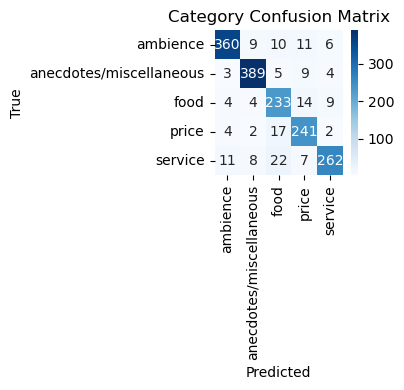

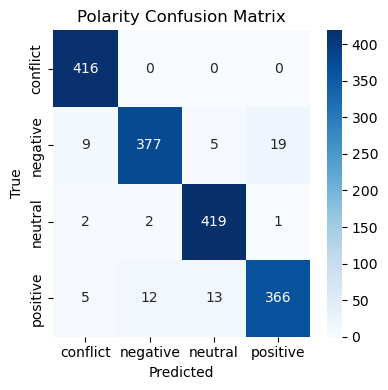

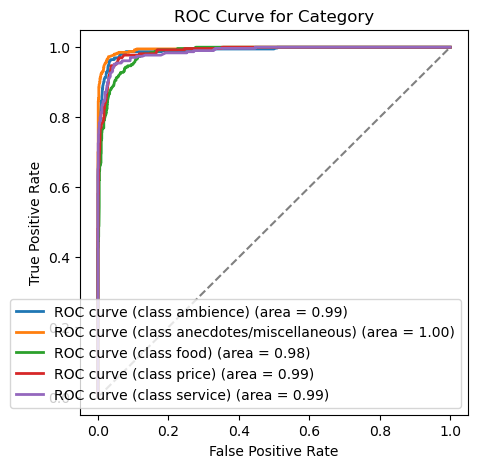

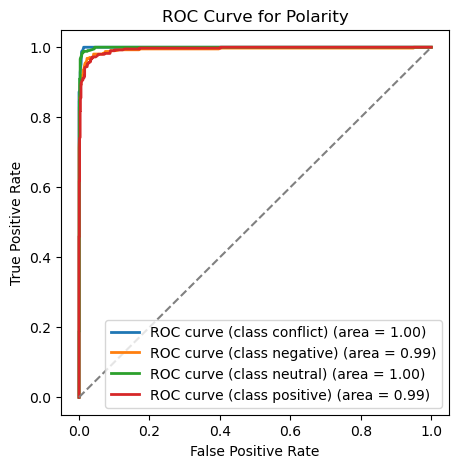

In [ ]:
# Step 1: Make predictions on the test set
# Prepare the test dataset
test_dataset = create_tensor_dataset(test_df)

# Get predictions from the model
predictions = multi_task_model.predict(test_dataset.batch(4))

# Assign predicted probabilities
category_probs = predictions[0]  # Predicted probabilities for category classes
polarity_probs = predictions[1]  # Predicted probabilities for polarity classes

# Step 2: Convert predictions to class labels
category_pred = np.argmax(category_probs, axis=1)  # Category predictions
polarity_pred = np.argmax(polarity_probs, axis=1)  # Polarity predictions

# Step 3: Convert true labels to numpy arrays
category_true = test_df['Category_encoded'].values
polarity_true = test_df['Polarity_encoded'].values

# Step 4: Calculate classification report for category and polarity
category_report = classification_report(category_true, category_pred, target_names=category_encoder.classes_)
polarity_report = classification_report(polarity_true, polarity_pred, target_names=polarity_encoder.classes_)

# Print the classification reports
print("Category Classification Report:\n", category_report)
print("Polarity Classification Report:\n", polarity_report)

# Step 5: Generate confusion matrices
category_cm = confusion_matrix(category_true, category_pred)
polarity_cm = confusion_matrix(polarity_true, polarity_pred)

# Category Confusion Matrix
plt.figure(figsize=(4, 4))
sns.heatmap(category_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=category_encoder.classes_, yticklabels=category_encoder.classes_)
plt.title('Category Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Polarity Confusion Matrix
plt.figure(figsize=(4, 4))
sns.heatmap(polarity_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=polarity_encoder.classes_, yticklabels=polarity_encoder.classes_)
plt.title('Polarity Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Step 6: ROC Curve and AUC Calculation for Multi-Class
# Binarize the labels for multi-class ROC
category_true_binarized = label_binarize(category_true, classes=np.arange(len(category_encoder.classes_)))
polarity_true_binarized = label_binarize(polarity_true, classes=np.arange(len(polarity_encoder.classes_)))

# Compute ROC curve and AUC for each class
fpr_category = {}
tpr_category = {}
roc_auc_category = {}
fpr_polarity = {}
tpr_polarity = {}
roc_auc_polarity = {}

# For category
for i in range(category_true_binarized.shape[1]):
    fpr_category[i], tpr_category[i], _ = roc_curve(category_true_binarized[:, i], category_probs[:, i])
    roc_auc_category[i] = auc(fpr_category[i], tpr_category[i])

# For polarity
for i in range(polarity_true_binarized.shape[1]):
    fpr_polarity[i], tpr_polarity[i], _ = roc_curve(polarity_true_binarized[:, i], polarity_probs[:, i])
    roc_auc_polarity[i] = auc(fpr_polarity[i], tpr_polarity[i])

# Plot ROC curves for Category
plt.figure(figsize=(5, 5))
for i in range(len(category_encoder.classes_)):
    plt.plot(fpr_category[i], tpr_category[i], lw=2,
             label='ROC curve (class %s) (area = %0.2f)' % (category_encoder.classes_[i], roc_auc_category[i]))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Category')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curves for Polarity
plt.figure(figsize=(5, 5))
for i in range(len(polarity_encoder.classes_)):
    plt.plot(fpr_polarity[i], tpr_polarity[i], lw=2,
             label='ROC curve (class %s) (area = %0.2f)' % (polarity_encoder.classes_[i], roc_auc_polarity[i]))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Polarity')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Step 7: Macro Precision, Recall, F1-Score Calculation
from sklearn.metrics import precision_score, recall_score, f1_score

# Macro precision, recall, and F1-score for category
macro_precision_category = precision_score(category_true, category_pred, average='macro')
macro_recall_category = recall_score(category_true, category_pred, average='macro')
macro_f1_category = f1_score(category_true, category_pred, average='macro')

# Macro precision, recall, and F1-score for polarity
macro_precision_polarity = precision_score(polarity_true, polarity_pred, average='macro')
macro_recall_polarity = recall_score(polarity_true, polarity_pred, average='macro')
macro_f1_polarity = f1_score(polarity_true, polarity_pred, average='macro')

# Print macro scores
print(f"Macro Precision (Category): {macro_precision_category:.4f}")
print(f"Macro Recall (Category): {macro_recall_category:.4f}")
print(f"Macro F1-Score (Category): {macro_f1_category:.4f}")
print(f"Macro Precision (Polarity): {macro_precision_polarity:.4f}")
print(f"Macro Recall (Polarity): {macro_recall_polarity:.4f}")
print(f"Macro F1-Score (Polarity): {macro_f1_polarity:.4f}")

Macro Precision (Category): 0.8958
Macro Recall (Category): 0.8983
Macro F1-Score (Category): 0.8962
Macro Precision (Polarity): 0.9585
Macro Recall (Polarity): 0.9580
Macro F1-Score (Polarity): 0.9580


In [ ]:
# Define a function to tokenize a single sentence
def tokenize_data(df_upsampled, max_length=128):
    input_ids = []
    attention_masks = []
    
    for sentence in df_upsampled['Text']:
        encoded_dict = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True, 
            max_length=max_length,    
            padding='max_length',    
            truncation=True,           
            return_attention_mask=True, 
            return_tensors='tf'        
        )
        
        # Append to lists
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    # Convert lists to tensors
    input_ids = tf.convert_to_tensor(input_ids)
    attention_masks = tf.convert_to_tensor(attention_masks)
    
    # Squeeze the extra dimension
    input_ids = tf.squeeze(input_ids, axis=1)
    attention_masks = tf.squeeze(attention_masks, axis=1)
    
    return input_ids, attention_masks

input_ids, attention_masks = tokenize_data(df_upsampled)

label_1 = tf.convert_to_tensor(df_upsampled['Category'])
label_2 = tf.convert_to_tensor(df_upsampled['Polarity'])

print(f"Input IDs shape: {input_ids.shape}")
print(f"Attention masks shape: {attention_masks.shape}")
print(f"Label 1 (Category) shape: {label_1.shape}")
print(f"Label 2 (Polarity) shape: {label_2.shape}")

Input IDs shape: (8228, 128)
Attention masks shape: (8228, 128)
Label 1 (Category) shape: (8228,)
Label 2 (Polarity) shape: (8228,)


In [ ]:
# Ensure input_ids and attention_masks are converted to integer type tensors
input_ids = tf.convert_to_tensor(input_ids, dtype=tf.int32)
attention_masks = tf.convert_to_tensor(attention_masks, dtype=tf.int32)

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Initialize label encoders for the string labels
label_encoder_1 = LabelEncoder()
label_encoder_2 = LabelEncoder()

# Encode string labels into integers
df_upsampled['Category'] = label_encoder_1.fit_transform(df_upsampled['Category'])
df_upsampled['Polarity'] = label_encoder_2.fit_transform(df_upsampled['Polarity'])

# Convert labels to TensorFlow tensors
label_1 = tf.convert_to_tensor(df_upsampled['Category'], dtype=tf.int32)
label_2 = tf.convert_to_tensor(df_upsampled['Polarity'], dtype=tf.int32)

# Ensure input_ids and attention_masks are correctly formatted as tensors
input_ids = tf.convert_to_tensor(input_ids, dtype=tf.int32)
attention_masks = tf.convert_to_tensor(attention_masks, dtype=tf.int32)

# Split the data into training and testing sets
X_train, X_test, att_mask_train, att_mask_test, y_cat_train, y_cat_test, y_gender_train, y_gender_test = train_test_split(
    input_ids.numpy(), attention_masks.numpy(),
    label_1.numpy(), label_2.numpy(),  
    test_size=0.2, random_state=42
)

In [ ]:
input_shape = X_train.shape[1]

In [ ]:
import tensorflow as tf

def create_bilstm_model(input_shape):
    input_ids = tf.keras.layers.Input(shape=(input_shape,), dtype='int32', name='input_ids')
    attention_masks = tf.keras.layers.Input(shape=(input_shape,), dtype='int32', name='attention_masks')

    # Embedding layer
    embedding_layer = tf.keras.layers.Embedding(input_dim=tokenizer.vocab_size, output_dim=128)(input_ids)

    # First BiLSTM layer with dropout
    lstm_output = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.3))(embedding_layer)

    # Second BiLSTM layer
    lstm_output_2 = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=False, dropout=0.3))(lstm_output)

    # Dense layer before output layers
    dense_layer = tf.keras.layers.Dense(64, activation='relu')(lstm_output_2)

    # Dropout layer for regularization
    dropout_layer = tf.keras.layers.Dropout(0.3)(dense_layer)

    # Output layers for multi-task learning
    output_category = tf.keras.layers.Dense(5, activation='softmax', name='Category')(dropout_layer)
    output_polarity = tf.keras.layers.Dense(4, activation='softmax', name='Polarity')(dropout_layer)

    # Define the model with inputs and outputs
    model = tf.keras.Model(inputs=[input_ids, attention_masks],
                           outputs=[output_category, output_polarity])

    return model

# Instantiate the BiLSTM model
bilstm_model = create_bilstm_model(input_shape)

# Compile the model
bilstm_model.compile(
    optimizer='adam',
    loss={'Category': 'sparse_categorical_crossentropy', 'Polarity': 'sparse_categorical_crossentropy'},
    metrics={'Category': 'accuracy', 'Polarity': 'accuracy'}
)

# Display the model summary
bilstm_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 128, 128)     13052800    ['input_ids[0][0]']              
                                                                                                  
 bidirectional (Bidirectional)  (None, 128, 256)     263168      ['embedding[0][0]']              
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 128)         164352      ['bidirectional[0][0]']          
 )                                                                                          

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
         
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Stop training after 3 epochs of no improvement
    restore_best_weights=True  # Restore the best weights from the epoch with the lowest validation loss
)

# Train the model with EarlyStopping
history = bilstm_model.fit(
    [X_train, att_mask_train],  # Inputs
    {'Category': y_cat_train, 'Polarity': y_gender_train},  # Outputs
    validation_split=0.1,
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]  # Add the EarlyStopping callback
)

Epoch 1/10
186/186 [==============================] - 30s 74ms/step - loss: 2.4490 - Category_loss: 1.3270 - Polarity_loss: 1.1220 - Category_accuracy: 0.4499 - Polarity_accuracy: 0.4668 - val_loss: 1.6991 - val_Category_loss: 0.9627 - val_Polarity_loss: 0.7365 - val_Category_accuracy: 0.5933 - val_Polarity_accuracy: 0.6525
Epoch 2/10
186/186 [==============================] - 12s 67ms/step - loss: 1.3479 - Category_loss: 0.7260 - Polarity_loss: 0.6219 - Category_accuracy: 0.7336 - Polarity_accuracy: 0.7307 - val_loss: 1.0332 - val_Category_loss: 0.5081 - val_Polarity_loss: 0.5251 - val_Category_accuracy: 0.8134 - val_Polarity_accuracy: 0.7724
Epoch 3/10
186/186 [==============================] - 12s 66ms/step - loss: 0.8464 - Category_loss: 0.4330 - Polarity_loss: 0.4134 - Category_accuracy: 0.8668 - Polarity_accuracy: 0.8484 - val_loss: 0.7389 - val_Category_loss: 0.4022 - val_Polarity_loss: 0.3367 - val_Category_accuracy: 0.8680 - val_Polarity_accuracy: 0.8816
Epoch 4/10
186/186 [==

In [ ]:
# Evaluate the model on the test set
results = bilstm_model.evaluate(
    [X_test, att_mask_test],
    {'Category': y_cat_test, 'Polarity': y_gender_test}
)

print(f"Test Loss and Accuracy: {results}")

52/52 [==============================] - 2s 31ms/step - loss: 0.4796 - Category_loss: 0.3396 - Polarity_loss: 0.1399 - Category_accuracy: 0.8985 - Polarity_accuracy: 0.9599
Test Loss and Accuracy: [0.47956299781799316, 0.3396154046058655, 0.13994769752025604, 0.8985419273376465, 0.959902822971344]


In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np

# Step 1: Get Predictions
predictions = bilstm_model.predict([X_test, att_mask_test])

# Step 2: Convert predictions to class labels
y_cat_pred = np.argmax(predictions[0], axis=1)   # 'Category' prediction
y_gender_pred = np.argmax(predictions[1], axis=1)  # 'Polarity' prediction

# Step 3: Generate Classification Report with zero_division specified
# For Category
print("Classification Report for Category:")
print(classification_report(y_cat_test, y_cat_pred, zero_division=0))

# For Polarity
print("\nClassification Report for Polarity:")
print(classification_report(y_gender_test, y_gender_pred, zero_division=0))

# If you want the macro-averaged precision, recall, and F1 scores separately:
cat_precision = precision_score(y_cat_test, y_cat_pred, average='macro', zero_division=0)
cat_recall = recall_score(y_cat_test, y_cat_pred, average='macro', zero_division=0)
cat_f1 = f1_score(y_cat_test, y_cat_pred, average='macro', zero_division=0)

gender_precision = precision_score(y_gender_test, y_gender_pred, average='macro', zero_division=0)
gender_recall = recall_score(y_gender_test, y_gender_pred, average='macro', zero_division=0)
gender_f1 = f1_score(y_gender_test, y_gender_pred, average='macro', zero_division=0)

print("\nMacro-Averaged Scores for Category:")
print(f"Precision: {cat_precision:.4f}, Recall: {cat_recall:.4f}, F1 Score: {cat_f1:.4f}")

print("\nMacro-Averaged Scores for Polarity:")
print(f"Precision: {gender_precision:.4f}, Recall: {gender_recall:.4f}, F1 Score: {gender_f1:.4f}")


52/52 [==============================] - 3s 28ms/step
Classification Report for Category:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       396
           1       0.94      0.93      0.94       410
           2       0.85      0.81      0.83       264
           3       0.87      0.91      0.89       266
           4       0.87      0.89      0.88       310

    accuracy                           0.90      1646
   macro avg       0.89      0.89      0.89      1646
weighted avg       0.90      0.90      0.90      1646


Classification Report for Polarity:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       416
           1       0.95      0.93      0.94       410
           2       0.97      0.99      0.98       424
           3       0.96      0.91      0.94       396

    accuracy                           0.96      1646
   macro avg       0.96      0.96      0.96      1646
weig

In [ ]:
import tensorflow as tf

def create_bilstm_model(input_shape):
    input_ids = tf.keras.layers.Input(shape=(input_shape,), dtype='int32', name='input_ids')
    attention_masks = tf.keras.layers.Input(shape=(input_shape,), dtype='int32', name='attention_masks')

    # Embedding layer
    embedding_layer = tf.keras.layers.Embedding(input_dim=tokenizer.vocab_size, output_dim=128)(input_ids)

    # First BiLSTM layer with dropout
    lstm_output = tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(128, return_sequences=True, dropout=0.3))(embedding_layer)

    # Second BiLSTM layer
    lstm_output_2 = tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(64, return_sequences=False, dropout=0.3))(lstm_output)

    # Dense layer before output layers
    dense_layer = tf.keras.layers.Dense(64, activation='relu')(lstm_output_2)

    # Dropout layer for regularization
    dropout_layer = tf.keras.layers.Dropout(0.3)(dense_layer)

    # Output layers for multi-task learning
    output_category = tf.keras.layers.Dense(5, activation='softmax', name='Category')(dropout_layer)
    output_polarity = tf.keras.layers.Dense(4, activation='softmax', name='Polarity')(dropout_layer)

    # Define the model with inputs and outputs
    model = tf.keras.Model(inputs=[input_ids, attention_masks],
                           outputs=[output_category, output_polarity])

    return model

# Instantiate the BiLSTM model
bilstm_model = create_bilstm_model(input_shape)

# Compile the model
bilstm_model.compile(
    optimizer='adam',
    loss={'Category': 'sparse_categorical_crossentropy', 'Polarity': 'sparse_categorical_crossentropy'},
    metrics={'Category': 'accuracy', 'Polarity': 'accuracy'}
)

# Display the model summary
bilstm_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 128, 128)     13052800    ['input_ids[0][0]']              
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 128, 256)    198144      ['embedding_1[0][0]']            
 )                                                                                                
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 128)         123648      ['bidirectional_2[0][0]']  

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
         
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3,       
    restore_best_weights=True 
)

# Train the model with EarlyStopping
history = bilstm_model.fit(
    [X_train, att_mask_train], 
    {'Category': y_cat_train, 'Polarity': y_gender_train}, 
    validation_split=0.1,
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]  
)


Epoch 1/10
186/186 [==============================] - 18s 67ms/step - loss: 2.2714 - Category_loss: 1.2472 - Polarity_loss: 1.0241 - Category_accuracy: 0.4753 - Polarity_accuracy: 0.5327 - val_loss: 1.3382 - val_Category_loss: 0.7263 - val_Polarity_loss: 0.6119 - val_Category_accuracy: 0.7466 - val_Polarity_accuracy: 0.7602
Epoch 2/10
186/186 [==============================] - 11s 59ms/step - loss: 1.1366 - Category_loss: 0.6551 - Polarity_loss: 0.4815 - Category_accuracy: 0.7699 - Polarity_accuracy: 0.8293 - val_loss: 0.8921 - val_Category_loss: 0.5295 - val_Polarity_loss: 0.3626 - val_Category_accuracy: 0.8209 - val_Polarity_accuracy: 0.8589
Epoch 3/10
186/186 [==============================] - 11s 59ms/step - loss: 0.7929 - Category_loss: 0.4739 - Polarity_loss: 0.3190 - Category_accuracy: 0.8475 - Polarity_accuracy: 0.8989 - val_loss: 0.7367 - val_Category_loss: 0.4441 - val_Polarity_loss: 0.2926 - val_Category_accuracy: 0.8528 - val_Polarity_accuracy: 0.9211
Epoch 4/10
186/186 [==

In [ ]:
# Evaluate the model on the test set
results = bilstm_model.evaluate(
    [X_test, att_mask_test],
    {'Category': y_cat_test, 'Polarity': y_gender_test}
)

print(f"Test Loss and Accuracy: {results}")

52/52 [==============================] - 1s 27ms/step - loss: 0.5147 - Category_loss: 0.3371 - Polarity_loss: 0.1776 - Category_accuracy: 0.8913 - Polarity_accuracy: 0.9496
Test Loss and Accuracy: [0.5147144794464111, 0.3371259868144989, 0.17758837342262268, 0.8912515044212341, 0.9495747089385986]


In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np

# Step 1: Get Predictions
predictions = bilstm_model.predict([X_test, att_mask_test])

# Step 2: Convert predictions to class labels
y_cat_pred = np.argmax(predictions[0], axis=1)   # 'Category' prediction
y_gender_pred = np.argmax(predictions[1], axis=1)  # 'Polarity' prediction

# Step 3: Generate Classification Report with zero_division specified
# For Category
print("Classification Report for Category:")
print(classification_report(y_cat_test, y_cat_pred, zero_division=0))

# For Polarity
print("\nClassification Report for Polarity:")
print(classification_report(y_gender_test, y_gender_pred, zero_division=0))

# If you want the macro-averaged precision, recall, and F1 scores separately:
cat_precision = precision_score(y_cat_test, y_cat_pred, average='macro', zero_division=0)
cat_recall = recall_score(y_cat_test, y_cat_pred, average='macro', zero_division=0)
cat_f1 = f1_score(y_cat_test, y_cat_pred, average='macro', zero_division=0)

gender_precision = precision_score(y_gender_test, y_gender_pred, average='macro', zero_division=0)
gender_recall = recall_score(y_gender_test, y_gender_pred, average='macro', zero_division=0)
gender_f1 = f1_score(y_gender_test, y_gender_pred, average='macro', zero_division=0)

print("\nMacro-Averaged Scores for Category:")
print(f"Precision: {cat_precision:.4f}, Recall: {cat_recall:.4f}, F1 Score: {cat_f1:.4f}")

print("\nMacro-Averaged Scores for Polarity:")
print(f"Precision: {gender_precision:.4f}, Recall: {gender_recall:.4f}, F1 Score: {gender_f1:.4f}")

52/52 [==============================] - 3s 26ms/step
Classification Report for Category:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       396
           1       0.94      0.94      0.94       410
           2       0.80      0.84      0.82       264
           3       0.87      0.86      0.87       266
           4       0.88      0.88      0.88       310

    accuracy                           0.89      1646
   macro avg       0.88      0.89      0.88      1646
weighted avg       0.89      0.89      0.89      1646


Classification Report for Polarity:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       416
           1       0.95      0.91      0.93       410
           2       0.96      0.98      0.97       424
           3       0.93      0.90      0.92       396

    accuracy                           0.95      1646
   macro avg       0.95      0.95      0.95      1646
weig

In [ ]:
from transformers import TFBertModel, BertTokenizer
import tensorflow as tf
from spektral.layers import GATConv
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Load Tokenizer
tokenizer = BertTokenizer.from_pretrained("sagorsarker/bangla-bert-base")

def tokenize_function(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='np')

# Assuming df_upsampled is your DataFrame with 'Text', 'Category_encoded', 'Polarity_encoded' columns
# df_upsampled['tokens'] = df_upsampled['Text'].apply(lambda x: tokenize_function(x))  # Not needed anymore

# 2. Define Adjacency Matrix Creation Function
def create_fully_connected_adjacency(seq_len):
    adjacency = np.ones((seq_len, seq_len)) - np.eye(seq_len)
    return adjacency.astype(np.float32)

# 3. Define TensorFlow Dataset Creation Function
def create_tensor_dataset(df, seq_len=128):
    inputs = tokenizer(
        list(df['Text']),
        padding='max_length',
        truncation=True,
        max_length=seq_len,
        return_tensors='tf'
    )
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    adjacency_matrices = np.array([create_fully_connected_adjacency(seq_len) for _ in range(len(df))])

    labels_category = tf.convert_to_tensor(df['Category_encoded'].values, dtype=tf.int32)
    labels_polarity = tf.convert_to_tensor(df['Polarity_encoded'].values, dtype=tf.int32)

    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'adjacency': adjacency_matrices
        },
        {
            'category_output': labels_category,
            'polarity_output': labels_polarity
        }
    ))

    return dataset

# 4. Split the Data
train_df, test_df = train_test_split(df_upsampled, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# 5. Create TensorFlow Datasets
train_dataset = create_tensor_dataset(train_df)
val_dataset = create_tensor_dataset(val_df)
test_dataset = create_tensor_dataset(test_df)  # Optional

# 6. Optimize the Datasets
BATCH_SIZE = 4
BUFFER_SIZE = 1000

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 7. Define BERT Layer
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = TFBertModel.from_pretrained("sagorsarker/bangla-bert-base")
    
    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)

# 8. Define Graph Attention Layer
class GraphAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, gat_units, num_heads, **kwargs):
        super(GraphAttentionLayer, self).__init__(**kwargs)
        self.gat = GATConv(channels=gat_units, heads=num_heads, activation='elu')
    
    def call(self, inputs, adjacency):
        return self.gat([inputs, adjacency])  # Shape: (batch_size, seq_len, gat_units * num_heads)

# 9. Define the Model Inputs
input_ids = tf.keras.Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.Input(shape=(128,), dtype=tf.int32, name='attention_mask')
adjacency = tf.keras.Input(shape=(128, 128), dtype=tf.float32, name='adjacency')  # Adjacency matrix input

# 10. BERT Layer
bert_output = BertLayer()([input_ids, attention_mask])  # (batch_size, seq_len, hidden_size)

# 11. Graph Attention Layer
gat_output = GraphAttentionLayer(gat_units=64, num_heads=4)(bert_output, adjacency)  # (batch_size, seq_len, 256)

# 12. Aggregate GAT Outputs (using CLS token)
cls_token = gat_output[:, 0, :]  # (batch_size, gat_units * num_heads)

# 13. Multi-task Outputs
category_output = tf.keras.layers.Dense(5, activation='softmax', name='category_output')(cls_token)
polarity_output = tf.keras.layers.Dense(4, activation='softmax', name='polarity_output')(cls_token)

# 14. Define the Model
multi_task_model = tf.keras.Model(
    inputs=[input_ids, attention_mask, adjacency],
    outputs=[category_output, polarity_output]
)

# 15. Compile the Model
multi_task_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss={
        'category_output': 'sparse_categorical_crossentropy',
        'polarity_output': 'sparse_categorical_crossentropy'
    },
    metrics=['accuracy']
)

multi_task_model.summary()

# 16. Train the Model
history = multi_task_model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset
)


f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are 

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 bert_layer_3 (BertLayer)       (None, 128, 768)     164396544   ['input_ids[0][0]',              
                                                                  'attention_mask[0][0]']         
                                                                                                  
 adjacency (InputLayer)         [(None, 128, 128)]   0           []                         

In [ ]:
# Evaluate on the test set
test_results = multi_task_model.evaluate(test_dataset)
print(f"Test Loss: {test_results[0]}")
print(f"Category Test Accuracy: {test_results[3]}")  # Adjust indices based on compiled metrics
print(f"Polarity Test Accuracy: {test_results[4]}")


412/412 [==============================] - 33s 79ms/step - loss: 0.4453 - category_output_loss: 0.3170 - polarity_output_loss: 0.1282 - category_output_accuracy: 0.9022 - polarity_output_accuracy: 0.9629
Test Loss: 0.4452541470527649
Category Test Accuracy: 0.9021871089935303
Polarity Test Accuracy: 0.9629404544830322


103/103 [==============================] - 21s 162ms/step
Category Classification Report:
                          precision    recall  f1-score   support

               ambience       0.94      0.90      0.92       396
anecdotes/miscellaneous       0.95      0.94      0.95       410
                   food       0.88      0.81      0.85       264
                  price       0.85      0.93      0.89       266
                service       0.86      0.90      0.88       310

               accuracy                           0.90      1646
              macro avg       0.90      0.90      0.90      1646
           weighted avg       0.90      0.90      0.90      1646

Polarity Classification Report:
               precision    recall  f1-score   support

    conflict       0.96      0.99      0.98       416
    negative       0.95      0.95      0.95       410
     neutral       0.97      1.00      0.98       424
    positive       0.98      0.92      0.95       396

    accuracy    

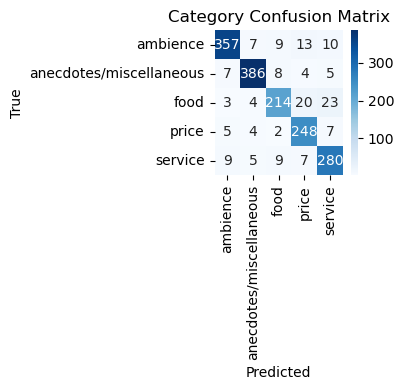

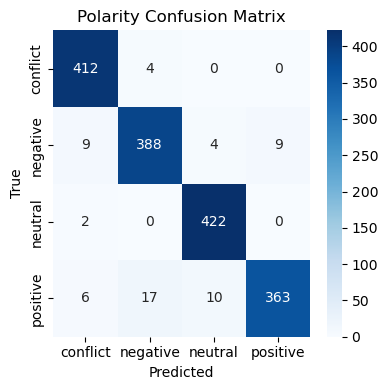

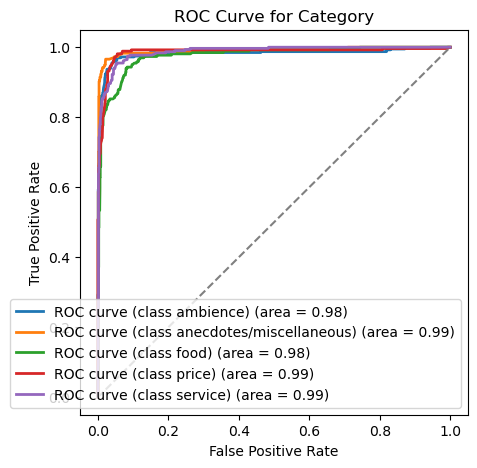

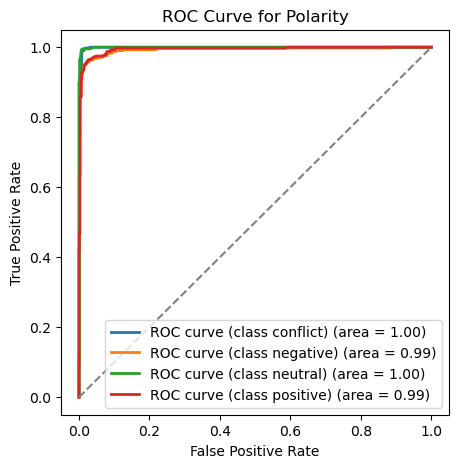

In [ ]:
# Step 1: Make predictions on the test set
# Prepare the test dataset
test_dataset = create_tensor_dataset(test_df)

# Get predictions from the model
predictions = multi_task_model.predict(test_dataset.batch(16))

# Assign predicted probabilities
category_probs = predictions[0]  # Predicted probabilities for category classes
polarity_probs = predictions[1]  # Predicted probabilities for polarity classes

# Step 2: Convert predictions to class labels
category_pred = np.argmax(category_probs, axis=1)  # Category predictions
polarity_pred = np.argmax(polarity_probs, axis=1)  # Polarity predictions

# Step 3: Convert true labels to numpy arrays
category_true = test_df['Category_encoded'].values
polarity_true = test_df['Polarity_encoded'].values

# Step 4: Calculate classification report for category and polarity
category_report = classification_report(category_true, category_pred, target_names=category_encoder.classes_)
polarity_report = classification_report(polarity_true, polarity_pred, target_names=polarity_encoder.classes_)

# Print the classification reports
print("Category Classification Report:\n", category_report)
print("Polarity Classification Report:\n", polarity_report)

# Step 5: Generate confusion matrices
category_cm = confusion_matrix(category_true, category_pred)
polarity_cm = confusion_matrix(polarity_true, polarity_pred)

# Category Confusion Matrix
plt.figure(figsize=(4, 4))
sns.heatmap(category_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=category_encoder.classes_, yticklabels=category_encoder.classes_)
plt.title('Category Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Polarity Confusion Matrix
plt.figure(figsize=(4, 4))
sns.heatmap(polarity_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=polarity_encoder.classes_, yticklabels=polarity_encoder.classes_)
plt.title('Polarity Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Step 6: ROC Curve and AUC Calculation for Multi-Class
# Binarize the labels for multi-class ROC
category_true_binarized = label_binarize(category_true, classes=np.arange(len(category_encoder.classes_)))
polarity_true_binarized = label_binarize(polarity_true, classes=np.arange(len(polarity_encoder.classes_)))

# Compute ROC curve and AUC for each class
fpr_category = {}
tpr_category = {}
roc_auc_category = {}
fpr_polarity = {}
tpr_polarity = {}
roc_auc_polarity = {}

# For category
for i in range(category_true_binarized.shape[1]):
    fpr_category[i], tpr_category[i], _ = roc_curve(category_true_binarized[:, i], category_probs[:, i])
    roc_auc_category[i] = auc(fpr_category[i], tpr_category[i])

# For polarity
for i in range(polarity_true_binarized.shape[1]):
    fpr_polarity[i], tpr_polarity[i], _ = roc_curve(polarity_true_binarized[:, i], polarity_probs[:, i])
    roc_auc_polarity[i] = auc(fpr_polarity[i], tpr_polarity[i])

# Plot ROC curves for Category
plt.figure(figsize=(5, 5))
for i in range(len(category_encoder.classes_)):
    plt.plot(fpr_category[i], tpr_category[i], lw=2,
             label='ROC curve (class %s) (area = %0.2f)' % (category_encoder.classes_[i], roc_auc_category[i]))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Category')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curves for Polarity
plt.figure(figsize=(5, 5))
for i in range(len(polarity_encoder.classes_)):
    plt.plot(fpr_polarity[i], tpr_polarity[i], lw=2,
             label='ROC curve (class %s) (area = %0.2f)' % (polarity_encoder.classes_[i], roc_auc_polarity[i]))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Polarity')
plt.legend(loc="lower right")
plt.show()


GNN

In [ ]:
from transformers import TFBertModel, BertTokenizer
import tensorflow as tf
from spektral.layers import GATConv
from tensorflow.keras.layers import Layer, Dropout
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Load Tokenizer
tokenizer = BertTokenizer.from_pretrained("sagorsarker/bangla-bert-base")

# 2. Define Adjacency Matrix Creation Functions
def create_syntactic_adjacency(seq_len):
    """Create a syntactic dependency adjacency matrix."""
    adjacency = np.eye(seq_len)  # Placeholder: No dependencies
    return adjacency.astype(np.float32)

def create_semantic_adjacency(seq_len):
    """Create a semantic similarity adjacency matrix."""
    adjacency = np.ones((seq_len, seq_len)) - np.eye(seq_len)  # Fully connected except self
    return adjacency.astype(np.float32)

def create_positional_adjacency(seq_len):
    """Create a positional adjacency matrix based on token positions."""
    adjacency = np.abs(np.subtract.outer(np.arange(seq_len), np.arange(seq_len)))
    adjacency = 1 / (1 + adjacency)  # Example transformation
    return adjacency.astype(np.float32)

# 3. Define TensorFlow Dataset Creation Function
def create_tensor_dataset(df, seq_len=128, num_heads=3):
    """
    Creates a TensorFlow Dataset from a dataframe, including multi-head adjacency matrices.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        seq_len (int, optional): Maximum sequence length. Defaults to 128.
        num_heads (int, optional): Number of adjacency matrix heads. Defaults to 3.

    Returns:
        tf.data.Dataset: TensorFlow Dataset yielding tuples of inputs and labels.
    """
    # Tokenize input text
    inputs = tokenizer(
        list(df['Text']),
        padding='max_length',
        truncation=True,
        max_length=seq_len,
        return_tensors='tf'
    )
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # Number of samples
    num_samples = len(df)

    # Create adjacency matrices for each sample and each head
    adjacency_matrices = np.array([
        np.stack([
            create_syntactic_adjacency(seq_len),
            create_semantic_adjacency(seq_len),
            create_positional_adjacency(seq_len)
        ], axis=0) for _ in range(num_samples)
    ])  # Shape: (num_samples, num_heads, 128, 128)

    print(f"Adjacency Matrices Shape: {adjacency_matrices.shape}")  # Should print (num_samples, 3, 128, 128)

    adjacency_matrices = adjacency_matrices.astype(np.float32)  # Ensure float32 type

    # Convert labels to tensors
    labels_category = tf.convert_to_tensor(df['Category_encoded'].values, dtype=tf.int32)
    labels_polarity = tf.convert_to_tensor(df['Polarity_encoded'].values, dtype=tf.int32)

    # Create the TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'adjacency': adjacency_matrices
        },
        {
            'category_output': labels_category,
            'polarity_output': labels_polarity
        }
    ))

    return dataset


# 4. Split the Data
train_df, test_df = train_test_split(df_upsampled, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# 5. Create TensorFlow Datasets
NUM_HEADS = 3
SEQ_LEN = 128
train_dataset = create_tensor_dataset(train_df, seq_len=SEQ_LEN, num_heads=NUM_HEADS)
val_dataset = create_tensor_dataset(val_df, seq_len=SEQ_LEN, num_heads=NUM_HEADS)
test_dataset = create_tensor_dataset(test_df, seq_len=SEQ_LEN, num_heads=NUM_HEADS)  # Optional

# 6. Optimize the Datasets
BATCH_SIZE = 4
BUFFER_SIZE = 1000

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 7. Define BERT Layer without tf.print
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = TFBertModel.from_pretrained("sagorsarker/bangla-bert-base")
    
    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        # tf.print("BERT output shape:", tf.shape(last_hidden_state))  # Removed for debugging
        return last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)

# 8. Define Multi-Head Graph Attention Layer without tf.print
class MultiHeadGraphAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, gat_units, num_heads, gat_num_attention_heads, **kwargs):
        super(MultiHeadGraphAttentionLayer, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.gat_num_attention_heads = gat_num_attention_heads
        self.gat_layers = [
            GATConv(channels=gat_units, heads=gat_num_attention_heads, activation='elu') 
            for _ in range(num_heads)
        ]
    
    def call(self, inputs):
        node_features, adjacency = inputs  # adjacency shape: (batch_size, num_heads, seq_len, seq_len)
        gat_outputs = []
        for head in range(self.num_heads):
            adjacency_head = adjacency[:, head, :, :]  # Shape: (batch_size, seq_len, seq_len)
            gat_layer = self.gat_layers[head]
            gat_output = gat_layer([node_features, adjacency_head])  # Shape: (batch_size, seq_len, gat_units * gat_num_attention_heads)
            # tf.print(f"GAT Output for head {head} shape:", tf.shape(gat_output))  # Removed for debugging
            gat_outputs.append(gat_output)
        # Concatenate outputs from all GAT layers along the last axis
        concatenated_gat = tf.concat(gat_outputs, axis=-1)  # Shape: (batch_size, seq_len, gat_units * gat_num_attention_heads * num_heads)
        # tf.print("Concatenated GAT output shape:", tf.shape(concatenated_gat))  # Removed for debugging
        return concatenated_gat

# 9. Define the Model Inputs
input_ids = tf.keras.Input(shape=(SEQ_LEN,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.Input(shape=(SEQ_LEN,), dtype=tf.int32, name='attention_mask')
adjacency = tf.keras.Input(shape=(NUM_HEADS, SEQ_LEN, SEQ_LEN), dtype=tf.float32, name='adjacency')  # Multi-head adjacency

# 10. BERT Layer
bert_output = BertLayer()([input_ids, attention_mask])  # Shape: (batch_size, seq_len, hidden_size)

# 11. Multi-Head Graph Attention Layer
GAT_UNITS = 64
GAT_NUM_ATTENTION_HEADS = 4  # Number of attention heads within each GATConv layer
gat_output = MultiHeadGraphAttentionLayer(
    gat_units=GAT_UNITS, 
    num_heads=NUM_HEADS, 
    gat_num_attention_heads=GAT_NUM_ATTENTION_HEADS
)([bert_output, adjacency])  # Shape: (batch_size, seq_len, gat_units * gat_num_attention_heads * num_heads)

# 12. Add Dropout for Regularization (Optional)
gat_output = Dropout(0.3)(gat_output)

# 13. Aggregate GAT Outputs (using CLS token)
cls_token = gat_output[:, 0, :]  # Shape: (batch_size, gat_units * gat_num_attention_heads * num_heads)
# tf.print("CLS Token Shape:", tf.shape(cls_token))  # Removed for debugging

# 14. Multi-task Outputs
category_output = tf.keras.layers.Dense(5, activation='softmax', name='category_output')(cls_token)
polarity_output = tf.keras.layers.Dense(4, activation='softmax', name='polarity_output')(cls_token)

# 15. Define the Model
multi_task_model = tf.keras.Model(
    inputs=[input_ids, attention_mask, adjacency],
    outputs=[category_output, polarity_output]
)

# 16. Compile the Model
multi_task_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss={
        'category_output': 'sparse_categorical_crossentropy',
        'polarity_output': 'sparse_categorical_crossentropy'
    },
    metrics=['accuracy']
)

# 17. Model Summary
multi_task_model.summary()

# 18. Train the Model without tf.print
history = multi_task_model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset
)


f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Adjacency Matrices Shape: (5923, 3, 128, 128)
Adjacency Matrices Shape: (659, 3, 128, 128)
Adjacency Matrices Shape: (1646, 3, 128, 128)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 bert_layer_4 (BertLayer)       (None, 128, 768)     164396544   ['input_ids[0][0]',              
                                                                  'attention_mask[0][0]']         
                                                                                                  
 adjacency (InputLayer)         [(None, 3, 128, 128  0           []                         

f:\Mini Conda\envs\env\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


 category_output (Dense)        (None, 5)            965         ['tf.__operators__.getitem_1[0][0
                                                                 ]']                              
                                                                                                  
 polarity_output (Dense)        (None, 4)            772         ['tf.__operators__.getitem_1[0][0
                                                                 ]']                              
                                                                                                  
Total params: 164,546,313
Trainable params: 164,546,313
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/5
1481/1481 [==============================] - 332s 213ms/step - loss: 1.6244 - category_output_loss: 0.8374 - polarity_output_loss: 0.7870 - category_output_accuracy: 0.7037 - polarity_output_accuracy: 0.7002 - val_los

In [ ]:
# Create the test dataset with batching
test_dataset = create_tensor_dataset(test_df)

# Evaluate the model on the test dataset
test_metrics = multi_task_model.evaluate(test_dataset.batch(4))
print(f"Test Category Loss: {test_metrics[1]}, Test Category Accuracy: {test_metrics[3]}")
print(f"Test Polarity Loss: {test_metrics[2]}, Test Polarity Accuracy: {test_metrics[4]}")

Adjacency Matrices Shape: (1646, 3, 128, 128)
412/412 [==============================] - 23s 56ms/step - loss: 0.4389 - category_output_loss: 0.3089 - polarity_output_loss: 0.1299 - category_output_accuracy: 0.9040 - polarity_output_accuracy: 0.9611
Test Category Loss: 0.30893877148628235, Test Category Accuracy: 0.9040096998214722
Test Polarity Loss: 0.1299135684967041, Test Polarity Accuracy: 0.9611178636550903


Adjacency Matrices Shape: (1646, 3, 128, 128)
412/412 [==============================] - 25s 54ms/step
Category Classification Report:
                          precision    recall  f1-score   support

               ambience       0.96      0.88      0.91       396
anecdotes/miscellaneous       0.92      0.97      0.94       410
                   food       0.91      0.81      0.86       264
                  price       0.85      0.94      0.89       266
                service       0.87      0.91      0.89       310

               accuracy                           0.90      1646
              macro avg       0.90      0.90      0.90      1646
           weighted avg       0.91      0.90      0.90      1646

Polarity Classification Report:
               precision    recall  f1-score   support

    conflict       0.96      1.00      0.98       416
    negative       0.97      0.92      0.94       410
     neutral       0.97      0.99      0.98       424
    positive       0.95   

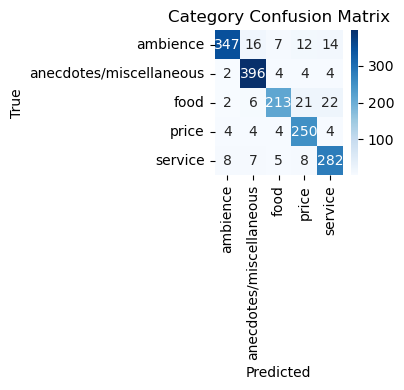

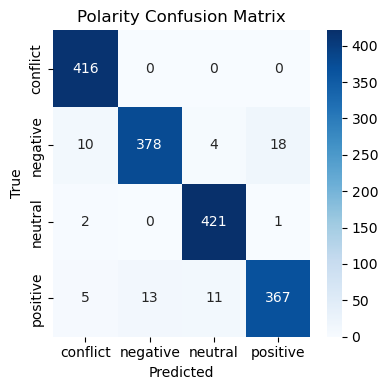

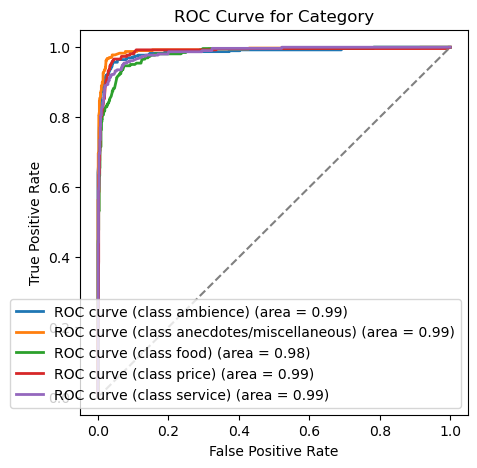

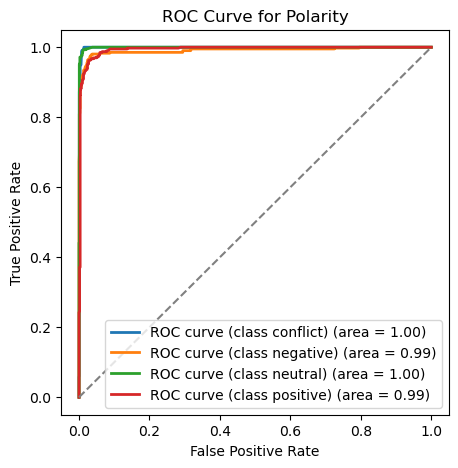

In [ ]:
# Prepare the test dataset
test_dataset = create_tensor_dataset(test_df)

# Get predictions from the model
predictions = multi_task_model.predict(test_dataset.batch(4))

# Assign predicted probabilities
category_probs = predictions[0]  # Predicted probabilities for category classes
polarity_probs = predictions[1]  # Predicted probabilities for polarity classes

# Step 2: Convert predictions to class labels
category_pred = np.argmax(category_probs, axis=1)  # Category predictions
polarity_pred = np.argmax(polarity_probs, axis=1)  # Polarity predictions

# Step 3: Convert true labels to numpy arrays
category_true = test_df['Category_encoded'].values
polarity_true = test_df['Polarity_encoded'].values

# Step 4: Calculate classification report for category and polarity
category_report = classification_report(category_true, category_pred, target_names=category_encoder.classes_)
polarity_report = classification_report(polarity_true, polarity_pred, target_names=polarity_encoder.classes_)

# Print the classification reports
print("Category Classification Report:\n", category_report)
print("Polarity Classification Report:\n", polarity_report)

# Step 5: Generate confusion matrices
category_cm = confusion_matrix(category_true, category_pred)
polarity_cm = confusion_matrix(polarity_true, polarity_pred)

# Category Confusion Matrix
plt.figure(figsize=(4, 4))
sns.heatmap(category_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=category_encoder.classes_, yticklabels=category_encoder.classes_)
plt.title('Category Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Polarity Confusion Matrix
plt.figure(figsize=(4, 4))
sns.heatmap(polarity_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=polarity_encoder.classes_, yticklabels=polarity_encoder.classes_)
plt.title('Polarity Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Step 6: ROC Curve and AUC Calculation for Multi-Class
# Binarize the labels for multi-class ROC
category_true_binarized = label_binarize(category_true, classes=np.arange(len(category_encoder.classes_)))
polarity_true_binarized = label_binarize(polarity_true, classes=np.arange(len(polarity_encoder.classes_)))

# Compute ROC curve and AUC for each class
fpr_category = {}
tpr_category = {}
roc_auc_category = {}
fpr_polarity = {}
tpr_polarity = {}
roc_auc_polarity = {}

# For category
for i in range(category_true_binarized.shape[1]):
    fpr_category[i], tpr_category[i], _ = roc_curve(category_true_binarized[:, i], category_probs[:, i])
    roc_auc_category[i] = auc(fpr_category[i], tpr_category[i])

# For polarity
for i in range(polarity_true_binarized.shape[1]):
    fpr_polarity[i], tpr_polarity[i], _ = roc_curve(polarity_true_binarized[:, i], polarity_probs[:, i])
    roc_auc_polarity[i] = auc(fpr_polarity[i], tpr_polarity[i])

# Plot ROC curves for Category
plt.figure(figsize=(5, 5))
for i in range(len(category_encoder.classes_)):
    plt.plot(fpr_category[i], tpr_category[i], lw=2,
             label='ROC curve (class %s) (area = %0.2f)' % (category_encoder.classes_[i], roc_auc_category[i]))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Category')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curves for Polarity
plt.figure(figsize=(5, 5))
for i in range(len(polarity_encoder.classes_)):
    plt.plot(fpr_polarity[i], tpr_polarity[i], lw=2,
             label='ROC curve (class %s) (area = %0.2f)' % (polarity_encoder.classes_[i], roc_auc_polarity[i]))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Polarity')
plt.legend(loc="lower right")
plt.show()


In [11]:
from transformers import TFBertModel, BertTokenizer
import tensorflow as tf
from spektral.layers import GCNConv
from tensorflow.keras.layers import Layer, Dropout
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Load Tokenizer
tokenizer = BertTokenizer.from_pretrained("sagorsarker/bangla-bert-base")

# 2. Define Adjacency Matrix Creation Functions
def create_syntactic_adjacency(seq_len):
    """Create a syntactic dependency adjacency matrix."""
    adjacency = np.eye(seq_len) 
    return adjacency.astype(np.float32)

def create_semantic_adjacency(seq_len):
    """Create a semantic similarity adjacency matrix."""
    adjacency = np.ones((seq_len, seq_len)) - np.eye(seq_len) 
    return adjacency.astype(np.float32)

def create_positional_adjacency(seq_len):
    """Create a positional adjacency matrix based on token positions."""
    adjacency = np.abs(np.subtract.outer(np.arange(seq_len), np.arange(seq_len)))
    adjacency = 1 / (1 + adjacency) 
    return adjacency.astype(np.float32)

# 3. Define TensorFlow Dataset Creation Function
def create_tensor_dataset(df, seq_len=128, num_heads=3):
    """
    Creates a TensorFlow Dataset from a dataframe, including multi-head adjacency matrices.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        seq_len (int, optional): Maximum sequence length. Defaults to 128.
        num_heads (int, optional): Number of adjacency matrix heads. Defaults to 3.

    Returns:
        tf.data.Dataset: TensorFlow Dataset yielding tuples of inputs and labels.
    """
    # Tokenize input text
    inputs = tokenizer(
        list(df['Text']),
        padding='max_length',
        truncation=True,
        max_length=seq_len,
        return_tensors='tf'
    )
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    num_samples = len(df)
    adjacency_matrices = np.array([
        np.stack([
            create_syntactic_adjacency(seq_len),
            create_semantic_adjacency(seq_len),
            create_positional_adjacency(seq_len)
        ], axis=0) for _ in range(num_samples)
    ]) 

    print(f"Adjacency Matrices Shape: {adjacency_matrices.shape}")

    adjacency_matrices = adjacency_matrices.astype(np.float32) 

    # Convert labels to tensors
    labels_category = tf.convert_to_tensor(df['Category_encoded'].values, dtype=tf.int32)
    labels_polarity = tf.convert_to_tensor(df['Polarity_encoded'].values, dtype=tf.int32)

    # Create the TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'adjacency': adjacency_matrices
        },
        {
            'category_output': labels_category,
            'polarity_output': labels_polarity
        }
    ))

    return dataset


# 4. Split the Data
train_df, test_df = train_test_split(df_upsampled, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# 5. Create TensorFlow Datasets
NUM_HEADS = 3
SEQ_LEN = 128
train_dataset = create_tensor_dataset(train_df, seq_len=SEQ_LEN, num_heads=NUM_HEADS)
val_dataset = create_tensor_dataset(val_df, seq_len=SEQ_LEN, num_heads=NUM_HEADS)
test_dataset = create_tensor_dataset(test_df, seq_len=SEQ_LEN, num_heads=NUM_HEADS) 

# 6. Optimize the Datasets
BATCH_SIZE = 4
BUFFER_SIZE = 1000

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 7. Define BERT Layer without tf.print
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = TFBertModel.from_pretrained("sagorsarker/bangla-bert-base")
    
    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        return last_hidden_state  

# 8. Define Multi-Head GCN Layer without tf.print
class MultiHeadGCNLayer(tf.keras.layers.Layer):
    def __init__(self, gcn_units, num_heads, **kwargs):
        """
        Initializes the MultiHeadGCNLayer.

        Args:
            gcn_units (int): Number of units per GCN layer.
            num_heads (int): Number of GCN layers (heads) to apply.
            **kwargs: Additional keyword arguments.
        """
        super(MultiHeadGCNLayer, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.gcn_layers = [
            GCNConv(channels=gcn_units, activation='relu') 
            for _ in range(num_heads)
        ]

    def call(self, inputs):
        """
        Forward pass for the MultiHeadGCNLayer.

        Args:
            inputs (tuple): A tuple containing node_features and adjacency matrices.
        
        Returns:
            tf.Tensor: Concatenated output from all GCN heads.
        """
        node_features, adjacency = inputs  
        gcn_outputs = []
        for head in range(self.num_heads):
            adjacency_head = adjacency[:, head, :, :] 
            gcn_layer = self.gcn_layers[head]
            gcn_output = gcn_layer([node_features, adjacency_head]) 
            gcn_outputs.append(gcn_output)
        concatenated_gcn = tf.concat(gcn_outputs, axis=-1)  
        return concatenated_gcn

# 9. Define the Model Inputs
input_ids = tf.keras.Input(shape=(SEQ_LEN,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.Input(shape=(SEQ_LEN,), dtype=tf.int32, name='attention_mask')
adjacency = tf.keras.Input(shape=(NUM_HEADS, SEQ_LEN, SEQ_LEN), dtype=tf.float32, name='adjacency') 

# 10. BERT Layer
bert_output = BertLayer()([input_ids, attention_mask]) 

# 11. Multi-Head GCN Layer
GNN_UNITS = 64
gcn_output = MultiHeadGCNLayer(
    gcn_units=GNN_UNITS, 
    num_heads=NUM_HEADS
)([bert_output, adjacency]) 

gcn_output = Dropout(0.3)(gcn_output)
cls_token = gcn_output[:, 0, :]

# 14. Multi-task Outputs
category_output = tf.keras.layers.Dense(5, activation='softmax', name='category_output')(cls_token)
polarity_output = tf.keras.layers.Dense(4, activation='softmax', name='polarity_output')(cls_token)

# 15. Define the Model
multi_task_model = tf.keras.Model(
    inputs=[input_ids, attention_mask, adjacency],
    outputs=[category_output, polarity_output]
)

# 16. Compile the Model
multi_task_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss={
        'category_output': 'sparse_categorical_crossentropy',
        'polarity_output': 'sparse_categorical_crossentropy'
    },
    metrics=['accuracy']
)

# 17. Model Summary
multi_task_model.summary()

# 18. Train the Model without tf.print
history = multi_task_model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset
)

f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Adjacency Matrices Shape: (5923, 3, 128, 128)
Adjacency Matrices Shape: (659, 3, 128, 128)
Adjacency Matrices Shape: (1646, 3, 128, 128)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 bert_layer (BertLayer)         (None, 128, 768)     164396544   ['input_ids[0][0]',              
                                                                  'attention_mask[0][0]']         
                                                                                                  
 adjacency (InputLayer)         [(None, 3, 128, 128  0           []                           

In [12]:
# Create the test dataset with batching
test_dataset = create_tensor_dataset(test_df)

# Evaluate the model on the test dataset
test_metrics = multi_task_model.evaluate(test_dataset.batch(4))
print(f"Test Category Loss: {test_metrics[1]}, Test Category Accuracy: {test_metrics[3]}")
print(f"Test Polarity Loss: {test_metrics[2]}, Test Polarity Accuracy: {test_metrics[4]}")


Adjacency Matrices Shape: (1646, 3, 128, 128)
412/412 [==============================] - 36s 86ms/step - loss: 0.5240 - category_output_loss: 0.3561 - polarity_output_loss: 0.1678 - category_output_accuracy: 0.8894 - polarity_output_accuracy: 0.9526
Test Category Loss: 0.3561253547668457, Test Category Accuracy: 0.8894289135932922
Test Polarity Loss: 0.1678326278924942, Test Polarity Accuracy: 0.9526124000549316


Adjacency Matrices Shape: (1646, 3, 128, 128)
412/412 [==============================] - 25s 54ms/step
Category Classification Report:
                          precision    recall  f1-score   support

               ambience       0.91      0.90      0.91       396
anecdotes/miscellaneous       0.93      0.94      0.93       410
                   food       0.85      0.80      0.83       264
                  price       0.85      0.88      0.86       266
                service       0.87      0.89      0.88       310

               accuracy                           0.89      1646
              macro avg       0.88      0.88      0.88      1646
           weighted avg       0.89      0.89      0.89      1646

Polarity Classification Report:
               precision    recall  f1-score   support

    conflict       0.97      1.00      0.98       416
    negative       0.96      0.90      0.93       410
     neutral       0.98      0.96      0.97       424
    positive       0.91   

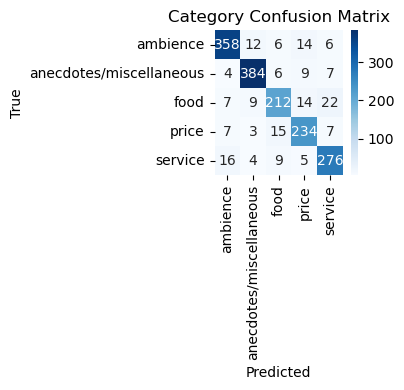

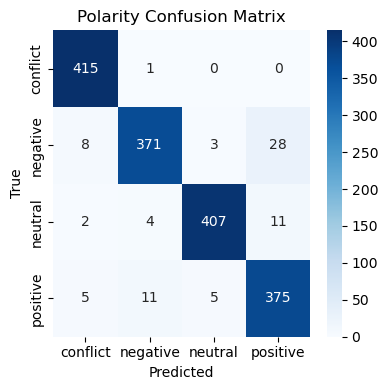

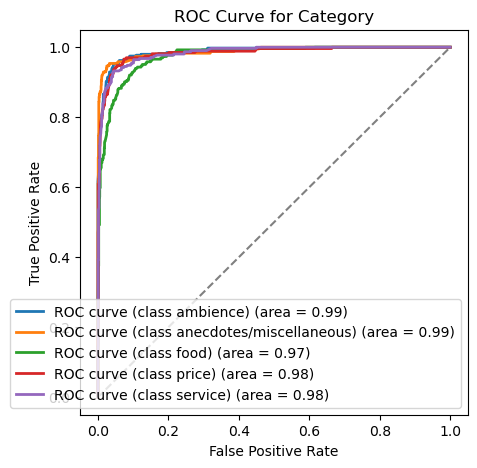

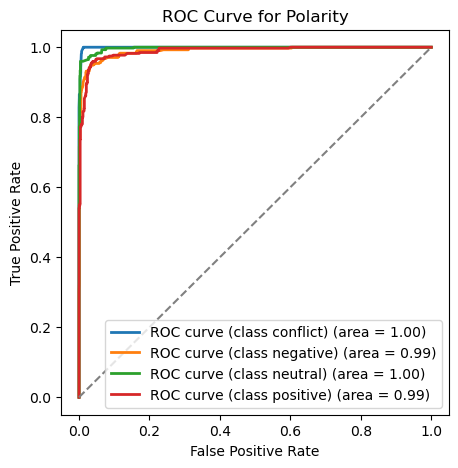

In [13]:
# Step 1: Make predictions on the test set
# Prepare the test dataset
test_dataset = create_tensor_dataset(test_df)

# Get predictions from the model
predictions = multi_task_model.predict(test_dataset.batch(4))

# Assign predicted probabilities
category_probs = predictions[0] 
polarity_probs = predictions[1]

# Step 2: Convert predictions to class labels
category_pred = np.argmax(category_probs, axis=1) 
polarity_pred = np.argmax(polarity_probs, axis=1) 

# Step 3: Convert true labels to numpy arrays
category_true = test_df['Category_encoded'].values
polarity_true = test_df['Polarity_encoded'].values

# Step 4: Calculate classification report for category and polarity
category_report = classification_report(category_true, category_pred, target_names=category_encoder.classes_)
polarity_report = classification_report(polarity_true, polarity_pred, target_names=polarity_encoder.classes_)

# Print the classification reports
print("Category Classification Report:\n", category_report)
print("Polarity Classification Report:\n", polarity_report)

# Step 5: Generate confusion matrices
category_cm = confusion_matrix(category_true, category_pred)
polarity_cm = confusion_matrix(polarity_true, polarity_pred)

# Category Confusion Matrix
plt.figure(figsize=(4, 4))
sns.heatmap(category_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=category_encoder.classes_, yticklabels=category_encoder.classes_)
plt.title('Category Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Polarity Confusion Matrix
plt.figure(figsize=(4, 4))
sns.heatmap(polarity_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=polarity_encoder.classes_, yticklabels=polarity_encoder.classes_)
plt.title('Polarity Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Step 6: ROC Curve and AUC Calculation for Multi-Class
# Binarize the labels for multi-class ROC
category_true_binarized = label_binarize(category_true, classes=np.arange(len(category_encoder.classes_)))
polarity_true_binarized = label_binarize(polarity_true, classes=np.arange(len(polarity_encoder.classes_)))

# Compute ROC curve and AUC for each class
fpr_category = {}
tpr_category = {}
roc_auc_category = {}
fpr_polarity = {}
tpr_polarity = {}
roc_auc_polarity = {}

# For category
for i in range(category_true_binarized.shape[1]):
    fpr_category[i], tpr_category[i], _ = roc_curve(category_true_binarized[:, i], category_probs[:, i])
    roc_auc_category[i] = auc(fpr_category[i], tpr_category[i])

# For polarity
for i in range(polarity_true_binarized.shape[1]):
    fpr_polarity[i], tpr_polarity[i], _ = roc_curve(polarity_true_binarized[:, i], polarity_probs[:, i])
    roc_auc_polarity[i] = auc(fpr_polarity[i], tpr_polarity[i])

# Plot ROC curves for Category
plt.figure(figsize=(5, 5))
for i in range(len(category_encoder.classes_)):
    plt.plot(fpr_category[i], tpr_category[i], lw=2,
             label='ROC curve (class %s) (area = %0.2f)' % (category_encoder.classes_[i], roc_auc_category[i]))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Category')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curves for Polarity
plt.figure(figsize=(5, 5))
for i in range(len(polarity_encoder.classes_)):
    plt.plot(fpr_polarity[i], tpr_polarity[i], lw=2,
             label='ROC curve (class %s) (area = %0.2f)' % (polarity_encoder.classes_[i], roc_auc_polarity[i]))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Polarity')
plt.legend(loc="lower right")
plt.show()


In [14]:
# Step 7: Generate Classification Report with zero_division specified
# For Category
print("Classification Report for Category:")
print(classification_report(category_true, category_pred, zero_division=0))

# For Polarity
print("\nClassification Report for Polarity:")
print(classification_report(polarity_true, polarity_pred, zero_division=0))

# Step 8: Macro-Averaged Precision, Recall, and F1 Scores
cat_precision = precision_score(category_true, category_pred, average='macro', zero_division=0)
cat_recall = recall_score(category_true, category_pred, average='macro', zero_division=0)
cat_f1 = f1_score(category_true, category_pred, average='macro', zero_division=0)

polarity_precision = precision_score(polarity_true, polarity_pred, average='macro', zero_division=0)
polarity_recall = recall_score(polarity_true, polarity_pred, average='macro', zero_division=0)
polarity_f1 = f1_score(polarity_true, polarity_pred, average='macro', zero_division=0)

print("\nMacro-Averaged Scores for Category:")
print(f"Precision: {cat_precision:.4f}, Recall: {cat_recall:.4f}, F1 Score: {cat_f1:.4f}")

print("\nMacro-Averaged Scores for Polarity:")
print(f"Precision: {polarity_precision:.4f}, Recall: {polarity_recall:.4f}, F1 Score: {polarity_f1:.4f}")

Classification Report for Category:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       396
           1       0.93      0.94      0.93       410
           2       0.85      0.80      0.83       264
           3       0.85      0.88      0.86       266
           4       0.87      0.89      0.88       310

    accuracy                           0.89      1646
   macro avg       0.88      0.88      0.88      1646
weighted avg       0.89      0.89      0.89      1646


Classification Report for Polarity:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       416
           1       0.96      0.90      0.93       410
           2       0.98      0.96      0.97       424
           3       0.91      0.95      0.93       396

    accuracy                           0.95      1646
   macro avg       0.95      0.95      0.95      1646
weighted avg       0.95      0.95      0.95      1646


Ma

In [15]:
from transformers import TFBertModel, BertTokenizer
import tensorflow as tf
from spektral.layers import GCNConv  # Import GCNConv instead of GATConv
from tensorflow.keras.layers import Layer, Dropout
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Load Tokenizer
tokenizer = BertTokenizer.from_pretrained("sagorsarker/bangla-bert-base")

# 2. Define Adjacency Matrix Creation Functions
def create_syntactic_adjacency(seq_len):
    """Create a syntactic dependency adjacency matrix."""
    adjacency = np.eye(seq_len)  # Placeholder: No dependencies
    return adjacency.astype(np.float32)

def create_semantic_adjacency(seq_len):
    """Create a semantic similarity adjacency matrix."""
    adjacency = np.ones((seq_len, seq_len)) - np.eye(seq_len)  # Fully connected except self
    return adjacency.astype(np.float32)

def create_positional_adjacency(seq_len):
    """Create a positional adjacency matrix based on token positions."""
    adjacency = np.abs(np.subtract.outer(np.arange(seq_len), np.arange(seq_len)))
    adjacency = 1 / (1 + adjacency)  # Example transformation
    return adjacency.astype(np.float32)

# 3. Define TensorFlow Dataset Creation Function
def create_tensor_dataset(df, seq_len=128, num_heads=3):
    """
    Creates a TensorFlow Dataset from a dataframe, including multi-head adjacency matrices.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        seq_len (int, optional): Maximum sequence length. Defaults to 128.
        num_heads (int, optional): Number of adjacency matrix heads. Defaults to 3.

    Returns:
        tf.data.Dataset: TensorFlow Dataset yielding tuples of inputs and labels.
    """
    # Tokenize input text
    inputs = tokenizer(
        list(df['Text']),
        padding='max_length',
        truncation=True,
        max_length=seq_len,
        return_tensors='tf'
    )
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # Number of samples
    num_samples = len(df)

    # Create adjacency matrices for each sample and each head
    adjacency_matrices = np.array([
        np.stack([
            create_syntactic_adjacency(seq_len),
            create_semantic_adjacency(seq_len),
            create_positional_adjacency(seq_len)
        ], axis=0) for _ in range(num_samples)
    ])  # Shape: (num_samples, 3, 128, 128)

    print(f"Adjacency Matrices Shape: {adjacency_matrices.shape}")  # Should print (num_samples, 3, 128, 128)

    adjacency_matrices = adjacency_matrices.astype(np.float32)  # Ensure float32 type

    # Convert labels to tensors
    labels_category = tf.convert_to_tensor(df['Category_encoded'].values, dtype=tf.int32)
    labels_polarity = tf.convert_to_tensor(df['Polarity_encoded'].values, dtype=tf.int32)

    # Create the TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'adjacency': adjacency_matrices
        },
        {
            'category_output': labels_category,
            'polarity_output': labels_polarity
        }
    ))

    return dataset


# 4. Split the Data
train_df, test_df = train_test_split(df_upsampled, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# 5. Create TensorFlow Datasets
NUM_HEADS = 3
SEQ_LEN = 128
train_dataset = create_tensor_dataset(train_df, seq_len=SEQ_LEN, num_heads=NUM_HEADS)
val_dataset = create_tensor_dataset(val_df, seq_len=SEQ_LEN, num_heads=NUM_HEADS)
test_dataset = create_tensor_dataset(test_df, seq_len=SEQ_LEN, num_heads=NUM_HEADS)  # Optional

# 6. Optimize the Datasets
BATCH_SIZE = 4
BUFFER_SIZE = 1000

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 7. Define BERT Layer without tf.print
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = TFBertModel.from_pretrained("sagorsarker/bangla-bert-base")
    
    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        return last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)

# 8. Define Multi-Head Graph Convolution Layer without tf.print
class MultiHeadGraphConvolutionLayer(tf.keras.layers.Layer):
    def __init__(self, gcn_units, num_heads, **kwargs):
        super(MultiHeadGraphConvolutionLayer, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.gcn_layers = [
            GCNConv(channels=gcn_units, activation='relu') 
            for _ in range(num_heads)
        ]

    def call(self, inputs):
        node_features, adjacency = inputs  # adjacency shape: (batch_size, num_heads, seq_len, seq_len)
        gcn_outputs = []
        for head in range(self.num_heads):
            adjacency_head = adjacency[:, head, :, :]  # Shape: (batch_size, seq_len, seq_len)
            gcn_layer = self.gcn_layers[head]
            gcn_output = gcn_layer([node_features, adjacency_head])  # Shape: (batch_size, seq_len, gcn_units)
            gcn_outputs.append(gcn_output)
        # Concatenate outputs from all GCN layers along the last axis
        concatenated_gcn = tf.concat(gcn_outputs, axis=-1)  # Shape: (batch_size, seq_len, gcn_units * num_heads)
        return concatenated_gcn

# 9. Define the Model Inputs
input_ids = tf.keras.Input(shape=(SEQ_LEN,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.Input(shape=(SEQ_LEN,), dtype=tf.int32, name='attention_mask')
adjacency = tf.keras.Input(shape=(NUM_HEADS, SEQ_LEN, SEQ_LEN), dtype=tf.float32, name='adjacency')  # Multi-head adjacency

# 10. BERT Layer
bert_output = BertLayer()([input_ids, attention_mask])  # Shape: (batch_size, seq_len, hidden_size)

# 11. Multi-Head Graph Convolution Layer
GCN_UNITS = 64  # Number of units per GCN layer
gcn_output = MultiHeadGraphConvolutionLayer(
    gcn_units=GCN_UNITS, 
    num_heads=NUM_HEADS
)([bert_output, adjacency])  # Shape: (batch_size, seq_len, gcn_units * num_heads)

# 12. Add Dropout for Regularization (Optional)
gcn_output = Dropout(0.3)(gcn_output)

# 13. Aggregate GCN Outputs (using CLS token)
cls_token = gcn_output[:, 0, :]  # Shape: (batch_size, gcn_units * num_heads)

# 14. Multi-task Outputs
category_output = tf.keras.layers.Dense(5, activation='softmax', name='category_output')(cls_token)
polarity_output = tf.keras.layers.Dense(4, activation='softmax', name='polarity_output')(cls_token)

# 15. Define the Model
multi_task_model = tf.keras.Model(
    inputs=[input_ids, attention_mask, adjacency],
    outputs=[category_output, polarity_output]
)

# 16. Compile the Model
multi_task_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss={
        'category_output': 'sparse_categorical_crossentropy',
        'polarity_output': 'sparse_categorical_crossentropy'
    },
    metrics=['accuracy']
)

# 17. Model Summary
multi_task_model.summary()

# 18. Train the Model without tf.print
history = multi_task_model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset
)

f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Adjacency Matrices Shape: (5923, 3, 128, 128)
Adjacency Matrices Shape: (659, 3, 128, 128)
Adjacency Matrices Shape: (1646, 3, 128, 128)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 bert_layer_1 (BertLayer)       (None, 128, 768)     164396544   ['input_ids[0][0]',              
                                                                  'attention_mask[0][0]']         
                                                                                                  
 adjacency (InputLayer)         [(None, 3, 128, 128  0           []                         